In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks, welch
from scipy.stats import skew, kurtosis

In [2]:
data_dir = Path("../data/first_dataset_initial_filtering")
pkl_files = sorted(data_dir.glob("*.pkl"))

dfs = [pd.read_pickle(f) for f in pkl_files]

In [3]:
dfs[18].head()

,sample_index,Fp1,Fp2,C3,C4,T3,T4,O1,O2,F3,F4,Fz,Pz,P3,P4,timestamp,marker,time_sec,timestamp_diff
0,194.0,7.753219,7.654809,1.470786,3.367101,1.653325,-0.793085,3.202809,-2.526580,5.167897,5.223019,3.985176,4.500262,2.862302,4.257304,1.747692e+09,0.0,0.000000,0.008119
1,196.0,49.333454,50.758591,21.372722,37.183758,25.357185,22.804067,59.244965,20.399585,-41.312441,-44.333181,-36.503119,-34.510988,-5.966836,-36.254665,1.747692e+09,0.0,0.007997,0.007997
2,198.0,26.856857,29.809523,12.310757,26.858605,2.954116,14.854198,37.608270,23.158700,-16.927104,-14.649980,-14.936230,-4.055406,5.775909,-2.548845,1.747692e+09,0.0,0.015981,0.007984
3,200.0,22.752166,25.911338,11.628797,27.577445,-3.560094,5.626867,31.978813,24.359520,-16.880493,-9.420436,-15.573908,3.258081,10.085829,6.150260,1.747692e+09,0.0,0.023989,0.008008
4,202.0,32.895589,35.834351,14.842163,33.292074,5.631253,20.711451,44.061476,21.930660,-30.125419,-22.922016,-27.255240,-5.619032,8.702297,-4.502894,1.747692e+09,0.0,0.032019,0.008030


In [4]:
timeline_df = pd.read_csv("../audio-timeline.csv")
# Converte colunas de timestamp para segundos
def hms_to_seconds(hms_str):
    h, m, s = map(int, hms_str.strip().split(":"))
    return h * 3600 + m * 60 + s

for col in ["sequence1", "sequence2", "sequence3"]:
    timeline_df[f"{col}_sec"] = timeline_df[col].apply(hms_to_seconds)

# Visualiza com as novas colunas
timeline_df

,target,sequence1,sequence2,sequence3,sequence1_sec,sequence2_sec,sequence3_sec
0,0,0:00:06,0:00:50,0:01:34,6,50,94
1,1,0:00:10,0:00:56,0:01:39,10,56,99
2,2,0:00:16,0:01:00,0:01:45,16,60,105
3,3,0:00:23,0:01:07,0:01:52,23,67,112
4,4,0:00:29,0:01:13,0:01:58,29,73,118
5,5,0:00:36,0:01:20,0:02:04,36,80,124
6,6,0:00:43,0:01:27,0:02:13,43,87,133


In [5]:
# List that will store the new DataFrames with target column
dfs_with_targets = []

# For each df (one block)
for df in dfs:
    df_new = df.copy()

    # Initialize target column as NaN
    df_new["target"] = None

    # Iterate through timeline
    for i, row in timeline_df.iterrows():
        start = 0 if i == 0 else timeline_df.loc[i - 1, "sequence1_sec"]
        end = row["sequence1_sec"]
        df_new.loc[(df_new["time_sec"] >= start) & (df_new["time_sec"] < end), "target"] = row["target"]

        # Repeat for sequence2
        start = 0 if i == 0 else timeline_df.loc[i - 1, "sequence2_sec"]
        end = row["sequence2_sec"]
        df_new.loc[(df_new["time_sec"] >= start) & (df_new["time_sec"] < end), "target"] = row["target"]

        # Repeat for sequence3
        start = 0 if i == 0 else timeline_df.loc[i - 1, "sequence3_sec"]
        end = row["sequence3_sec"]
        df_new.loc[(df_new["time_sec"] >= start) & (df_new["time_sec"] < end), "target"] = row["target"]

    # Ensure target is integer
    df_new["target"] = df_new["target"].astype("Int64")

    dfs_with_targets.append(df_new)


In [6]:
dfs_with_targets[18]

,sample_index,Fp1,Fp2,C3,C4,T3,T4,O1,O2,F3,F4,Fz,Pz,P3,P4,timestamp,marker,time_sec,timestamp_diff,target
0,194.0,7.753219,7.654809,1.470786,3.367101,1.653325,-0.793085,3.202809,-2.526580,5.167897,5.223019,3.985176,4.500262,2.862302,4.257304,1.747692e+09,0.0,0.000000,0.008119,0
1,196.0,49.333454,50.758591,21.372722,37.183758,25.357185,22.804067,59.244965,20.399585,-41.312441,-44.333181,-36.503119,-34.510988,-5.966836,-36.254665,1.747692e+09,0.0,0.007997,0.007997,0
2,198.0,26.856857,29.809523,12.310757,26.858605,2.954116,14.854198,37.608270,23.158700,-16.927104,-14.649980,-14.936230,-4.055406,5.775909,-2.548845,1.747692e+09,0.0,0.015981,0.007984,0
3,200.0,22.752166,25.911338,11.628797,27.577445,-3.560094,5.626867,31.978813,24.359520,-16.880493,-9.420436,-15.573908,3.258081,10.085829,6.150260,1.747692e+09,0.0,0.023989,0.008008,0
4,202.0,32.895589,35.834351,14.842163,33.292074,5.631253,20.711451,44.061476,21.930660,-30.125419,-22.922016,-27.255240,-5.619032,8.702297,-4.502894,1.747692e+09,0.0,0.032019,0.008030,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16666,246.0,18.300290,10.744635,-4.759181,5.513199,5.634423,-8.087288,18.896845,-50.822310,34.665678,33.452099,16.427773,28.941127,6.884469,21.599503,1.747692e+09,0.0,133.267526,0.008001,<NA>
16667,248.0,8.049270,2.042364,-7.596102,-2.561690,1.115842,-16.034833,14.925883,-40.740131,16.284212,8.963090,1.020426,11.656175,-2.360205,4.472622,1.747692e+09,0.0,133.275622,0.008096,<NA>
16668,250.0,13.555044,10.015143,4.261118,11.999589,4.567227,-4.996574,21.370714,-36.614406,22.615134,18.280704,8.893716,23.207279,9.441677,15.427447,1.747692e+09,0.0,133.282589,0.006967,<NA>
16669,252.0,38.705392,38.637390,20.551810,41.273656,17.534921,27.947119,41.313717,-45.729686,64.524370,67.312764,43.817244,62.172341,32.730838,53.473925,1.747692e+09,0.0,133.291615,0.009026,<NA>


In [7]:
max_music_duration = 133.0  # seconds

dfs_trimmed = [df[df["time_sec"] <= max_music_duration].copy() for df in dfs_with_targets]
dfs_trimmed[18]

,sample_index,Fp1,Fp2,C3,C4,T3,T4,O1,O2,F3,F4,Fz,Pz,P3,P4,timestamp,marker,time_sec,timestamp_diff,target
0,194.0,7.753219,7.654809,1.470786,3.367101,1.653325,-0.793085,3.202809,-2.526580,5.167897,5.223019,3.985176,4.500262,2.862302,4.257304,1.747692e+09,0.0,0.000000,0.008119,0
1,196.0,49.333454,50.758591,21.372722,37.183758,25.357185,22.804067,59.244965,20.399585,-41.312441,-44.333181,-36.503119,-34.510988,-5.966836,-36.254665,1.747692e+09,0.0,0.007997,0.007997,0
2,198.0,26.856857,29.809523,12.310757,26.858605,2.954116,14.854198,37.608270,23.158700,-16.927104,-14.649980,-14.936230,-4.055406,5.775909,-2.548845,1.747692e+09,0.0,0.015981,0.007984,0
3,200.0,22.752166,25.911338,11.628797,27.577445,-3.560094,5.626867,31.978813,24.359520,-16.880493,-9.420436,-15.573908,3.258081,10.085829,6.150260,1.747692e+09,0.0,0.023989,0.008008,0
4,202.0,32.895589,35.834351,14.842163,33.292074,5.631253,20.711451,44.061476,21.930660,-30.125419,-22.922016,-27.255240,-5.619032,8.702297,-4.502894,1.747692e+09,0.0,0.032019,0.008030,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16628,170.0,-10.245404,-5.681293,1.173135,-4.495413,-6.434117,-0.858895,-1.997253,11.038639,-3.242737,-4.976824,-1.988229,-4.465390,0.836800,-5.154018,1.747692e+09,0.0,132.965423,0.007985,6
16629,172.0,-12.296817,-6.224449,-4.924857,-7.933979,-6.461799,-0.527775,-7.851352,9.049686,-6.564712,-10.548799,-8.922902,-13.468666,-7.661604,-13.548278,1.747692e+09,0.0,132.974486,0.009063,6
16630,174.0,-11.408842,-6.291086,-4.892649,-6.707653,-2.763055,2.861691,-6.164184,12.421679,-9.014616,-11.416326,-9.342240,-13.107019,-8.610103,-12.450487,1.747692e+09,0.0,132.982500,0.008014,6
16631,176.0,-9.324074,-5.668038,-2.700583,-2.657402,-0.668051,0.766055,2.890646,14.415933,-4.179630,-4.882257,-3.884029,-5.754288,-2.253366,-3.621695,1.747692e+09,0.0,132.990548,0.008048,6


In [8]:
# Filter all blocks, removing rows with target == 0
dfs_no_target_0 = [df[df["target"] != 0].copy() for df in dfs_trimmed]
dfs_no_target_0[18]


,sample_index,Fp1,Fp2,C3,C4,T3,T4,O1,O2,F3,F4,Fz,Pz,P3,P4,timestamp,marker,time_sec,timestamp_diff,target
751,160.0,4.648765,7.425719,6.187098,5.662294,3.598167,20.212209,-0.846586,-2.560603,1.611061,1.256217,2.608183,4.761602,6.940722,2.956699,1.747692e+09,0.0,6.004982,0.007967,1
752,162.0,1.869183,4.688483,5.721914,6.637207,4.668509,-0.747465,-2.772198,-2.300413,1.532534,3.606452,2.688025,5.858570,7.789084,3.132108,1.747692e+09,0.0,6.013063,0.008081,1
753,164.0,4.953371,6.928469,7.430552,7.289979,11.537378,-11.560196,-2.967949,-0.298426,5.137756,5.766060,5.000048,10.720159,9.569045,6.878705,1.747692e+09,0.0,6.021028,0.007965,1
754,166.0,8.686257,9.320479,7.141610,7.510423,10.359865,-6.674401,-6.313351,0.423021,9.041574,5.680081,7.078761,10.373154,7.460221,7.043760,1.747692e+09,0.0,6.032082,0.011054,1
755,168.0,8.875100,8.247527,8.920232,11.515157,6.673360,-4.898628,-8.539462,3.446222,10.395597,6.038059,8.040103,5.170913,1.072928,5.916785,1.747692e+09,0.0,6.038088,0.006006,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16628,170.0,-10.245404,-5.681293,1.173135,-4.495413,-6.434117,-0.858895,-1.997253,11.038639,-3.242737,-4.976824,-1.988229,-4.465390,0.836800,-5.154018,1.747692e+09,0.0,132.965423,0.007985,6
16629,172.0,-12.296817,-6.224449,-4.924857,-7.933979,-6.461799,-0.527775,-7.851352,9.049686,-6.564712,-10.548799,-8.922902,-13.468666,-7.661604,-13.548278,1.747692e+09,0.0,132.974486,0.009063,6
16630,174.0,-11.408842,-6.291086,-4.892649,-6.707653,-2.763055,2.861691,-6.164184,12.421679,-9.014616,-11.416326,-9.342240,-13.107019,-8.610103,-12.450487,1.747692e+09,0.0,132.982500,0.008014,6
16631,176.0,-9.324074,-5.668038,-2.700583,-2.657402,-0.668051,0.766055,2.890646,14.415933,-4.179630,-4.882257,-3.884029,-5.754288,-2.253366,-3.621695,1.747692e+09,0.0,132.990548,0.008048,6


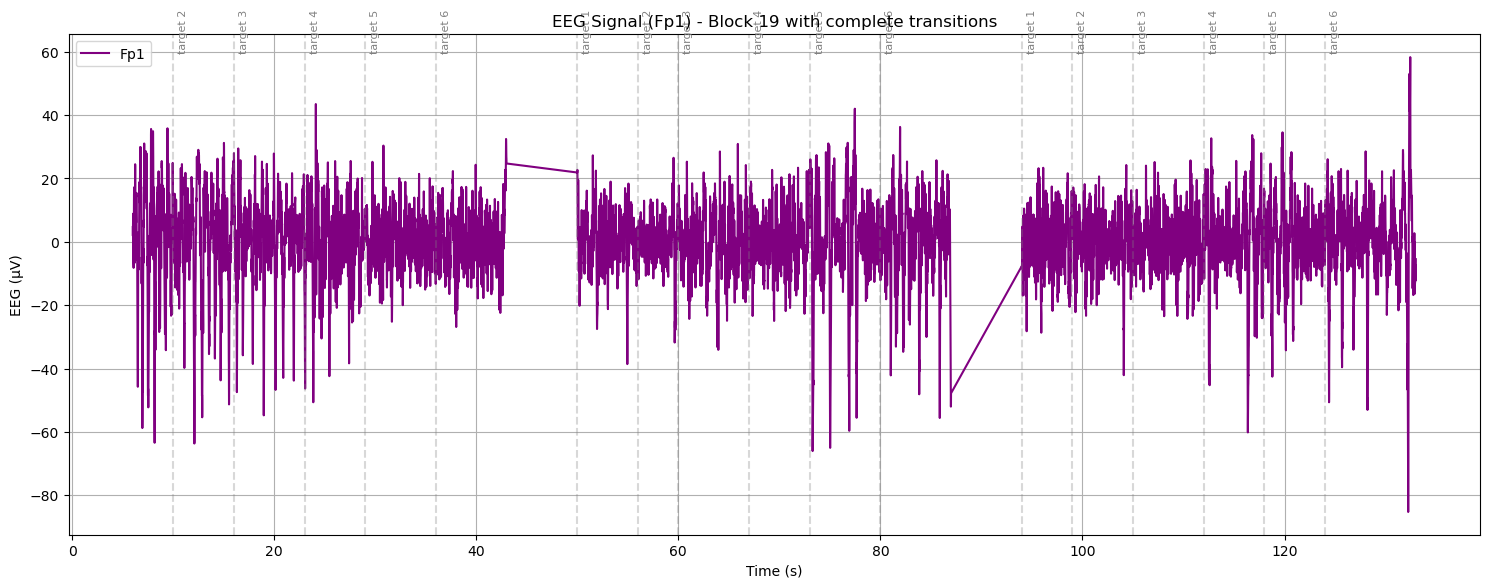

In [9]:
df_plot = dfs_no_target_0[18]

plt.figure(figsize=(15, 6))
plt.plot(df_plot["time_sec"], df_plot["Fp1"], label="Fp1", color="purple")

# Identify where target changes
transitions = df_plot["target"].ne(df_plot["target"].shift())
transition_points = df_plot[transitions]

# Mark all transitions with vertical lines
for _, row in transition_points.iterrows():
    t = row["target"]
    t_time = row["time_sec"]
    plt.axvline(t_time, color="gray", linestyle="--", alpha=0.3)
    plt.text(t_time + 0.5, 60, f"target {t}", fontsize=8, color="gray", rotation=90)

plt.title("EEG Signal (Fp1) - Block 19 with complete transitions")
plt.xlabel("Time (s)")
plt.ylabel("EEG (µV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


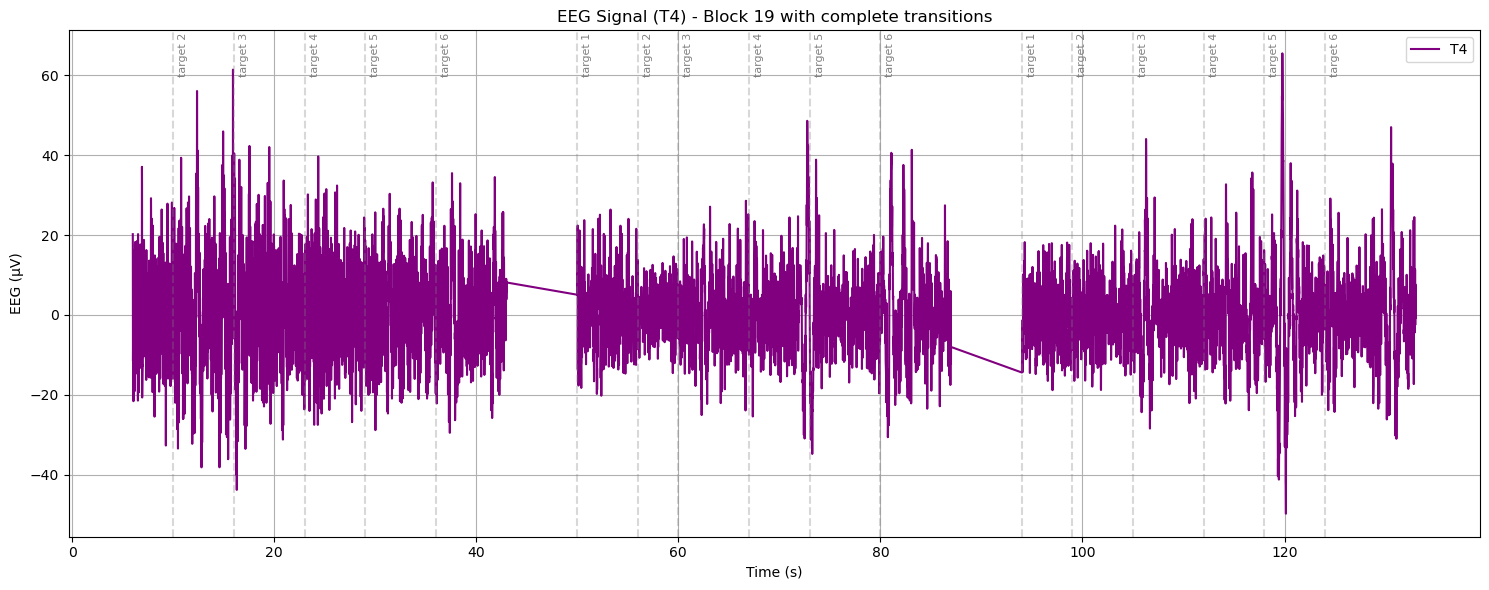

In [10]:
df_plot = dfs_no_target_0[18]

plt.figure(figsize=(15, 6))
plt.plot(df_plot["time_sec"], df_plot["T4"], label="T4", color="purple")

# Identify where target changes
transitions = df_plot["target"].ne(df_plot["target"].shift())
transition_points = df_plot[transitions]

# Mark all transitions with vertical lines
for _, row in transition_points.iterrows():
    t = row["target"]
    t_time = row["time_sec"]
    plt.axvline(t_time, color="gray", linestyle="--", alpha=0.3)
    plt.text(t_time + 0.5, 60, f"target {t}", fontsize=8, color="gray", rotation=90)

plt.title("EEG Signal (T4) - Block 19 with complete transitions")
plt.xlabel("Time (s)")
plt.ylabel("EEG (µV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## KNN (K-Nearest Neighbors)
- Very simple and straightforward
- Serves as a control: if it already classifies well, the data has basic separability
- Reacts quickly to overfitting → good indicator of feature quality


In [11]:
# Parameters
eeg_channels = ["Fp1", "Fp2", "C3", "C4", "T3", "T4", "O1", "O2",
                "F3", "F4", "Fz", "Pz", "P3", "P4"]


def extract_features(df_window, fs=125):
    features = {}
    for ch in eeg_channels:
        signal = df_window[ch].values

        # Simple statistics
        features[f"{ch}_mean"] = np.mean(signal)
        features[f"{ch}_std"] = np.std(signal)
        features[f"{ch}_skew"] = skew(signal)
        features[f"{ch}_kurt"] = kurtosis(signal)

        # Band power (alpha)
        f, psd = welch(signal, fs=fs, nperseg=128)
        alpha_band = (f >= 8) & (f <= 12)
        features[f"{ch}_alpha"] = np.trapz(psd[alpha_band], f[alpha_band])

    return features


In [12]:
window_size = 2  # segundos
fs = 125
samples_per_window = window_size * fs

feature_rows = []

for df in dfs_no_target_0:
    for i in range(0, len(df), samples_per_window):
        df_window = df.iloc[i:i+samples_per_window]
        if len(df_window) < samples_per_window:
            continue
        target = df_window["target"].iloc[0]
        row = extract_features(df_window, fs=fs)
        row["target"] = target
        feature_rows.append(row)

df_features = pd.DataFrame(feature_rows)


/var/folders/ny/tk1xvwsn7n11pkl0vlgl1sz80000gn/T/ipykernel_26117/3187937389.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  features[f"{ch}_alpha"] = np.trapz(psd[alpha_band], f[alpha_band])


In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

X = df_features.drop(columns=["target"])
y = df_features["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.17      0.39      0.23        28
           2       0.20      0.29      0.24        34
           3       0.18      0.22      0.19        46
           4       0.06      0.03      0.04        36
           5       0.08      0.05      0.06        40
           6       0.45      0.12      0.20        40

    accuracy                           0.17       224
   macro avg       0.19      0.18      0.16       224
weighted avg       0.19      0.17      0.16       224



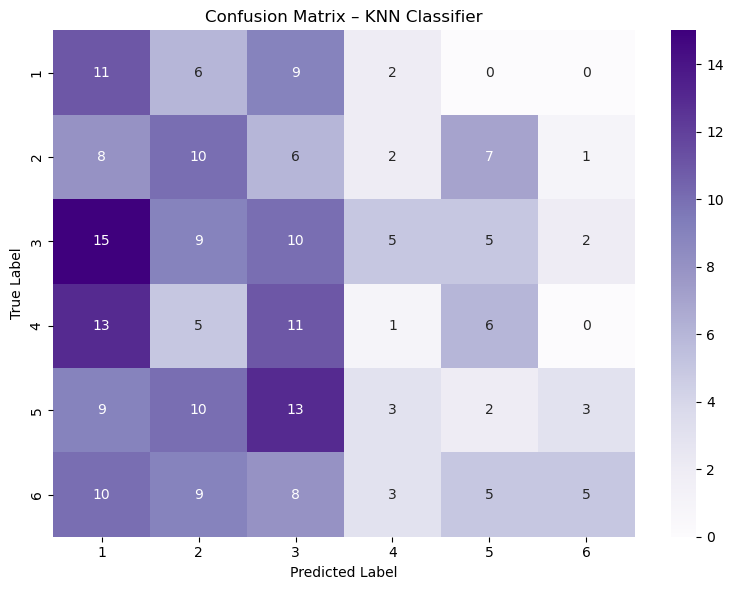

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.sort(y.unique()))

# Create a labeled heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=np.sort(y.unique()),
            yticklabels=np.sort(y.unique()))

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – KNN Classifier")
plt.tight_layout()
plt.show()
